<a href="https://colab.research.google.com/github/hannakb/Neurons-Importance/blob/master/linear_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/My Drive/Neuron Importance/cnn_with_my_utils'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Neuron Importance/cnn_with_my_utils


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook as tqdm
from  tqdm import tqdm_notebook as tqdm
from tqdm import trange

from my_utilities import StatsOneLayer, load_data, train_epoch, calc_acc, prune_layer

%matplotlib inline

In [0]:
train_loader, valid_loader, test_loader = load_data('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 1000),
    nn.ReLU(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(-1)
)
intermediate_layers = [2, 4, 6]

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# n_layers x 3 metrics x n_epoch (it appended)
stats = [[[] for _ in range(3)] for _ in intermediate_layers]
train_accuracy = []
valid_accuracy = []
model = model.cuda()

In [0]:
n_epoch = 20
for ep_ind in trange(n_epoch):
    # print("Epoch {} / {}".format(ep_ind + 1, n_epoch))
    model.train()
    train_epoch(model, train_loader, optimizer, criterion, device='cuda')
    model.eval()
    for ind, layer_ind in enumerate(intermediate_layers):
        curr_stats = StatsOneLayer(model[:layer_ind + 1], 10, valid_loader, device='cuda')
        stats[ind][0].append(curr_stats.entropy)
        stats[ind][1].append(curr_stats.mi)
        stats[ind][2].append(curr_stats.kl)
    train_accuracy.append(calc_acc(model, train_loader, 'cuda'))
    valid_accuracy.append(calc_acc(model, valid_loader, 'cuda'))
    print("Train accuracy {}, validation accuracy {}".format(
        train_accuracy[-1], valid_accuracy[-1]))

  5%|▌         | 1/20 [00:19<06:11, 19.54s/it]

Train accuracy 0.686225, validation accuracy 0.4986


 10%|█         | 2/20 [00:39<05:51, 19.52s/it]

Train accuracy 0.6936, validation accuracy 0.5033


 15%|█▌        | 3/20 [00:58<05:32, 19.55s/it]

Train accuracy 0.692125, validation accuracy 0.4951


 20%|██        | 4/20 [01:18<05:14, 19.67s/it]

Train accuracy 0.708975, validation accuracy 0.5061


 25%|██▌       | 5/20 [01:38<04:54, 19.63s/it]

Train accuracy 0.70775, validation accuracy 0.4985


 30%|███       | 6/20 [01:57<04:34, 19.63s/it]

Train accuracy 0.713225, validation accuracy 0.5054


 35%|███▌      | 7/20 [02:17<04:15, 19.68s/it]

Train accuracy 0.7103, validation accuracy 0.5017


 40%|████      | 8/20 [02:37<03:57, 19.80s/it]

Train accuracy 0.71735, validation accuracy 0.5054


 45%|████▌     | 9/20 [02:57<03:37, 19.80s/it]

Train accuracy 0.724825, validation accuracy 0.5045


 50%|█████     | 10/20 [03:17<03:18, 19.80s/it]

Train accuracy 0.722275, validation accuracy 0.5031


 55%|█████▌    | 11/20 [03:36<02:57, 19.72s/it]

Train accuracy 0.723075, validation accuracy 0.5021


 60%|██████    | 12/20 [03:56<02:38, 19.76s/it]

Train accuracy 0.732275, validation accuracy 0.5042


 65%|██████▌   | 13/20 [04:16<02:18, 19.78s/it]

Train accuracy 0.7355, validation accuracy 0.4994


 70%|███████   | 14/20 [04:36<01:58, 19.74s/it]

Train accuracy 0.735775, validation accuracy 0.5107


 75%|███████▌  | 15/20 [04:55<01:38, 19.75s/it]

Train accuracy 0.73575, validation accuracy 0.5039


 80%|████████  | 16/20 [05:15<01:19, 19.80s/it]

Train accuracy 0.739475, validation accuracy 0.505


 85%|████████▌ | 17/20 [05:35<00:59, 19.78s/it]

Train accuracy 0.7423, validation accuracy 0.5075


 90%|█████████ | 18/20 [05:55<00:39, 19.84s/it]

Train accuracy 0.747625, validation accuracy 0.5051


 95%|█████████▌| 19/20 [06:15<00:19, 19.76s/it]

Train accuracy 0.746825, validation accuracy 0.5067


100%|██████████| 20/20 [06:34<00:00, 19.79s/it]

Train accuracy 0.756525, validation accuracy 0.5078


In [0]:
import pickle
with open('linear_cifar_model.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([model.state_dict(), stats], f)

# with open('cnn_cifar_model.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#     model_sd, stats = pickle.load(f)

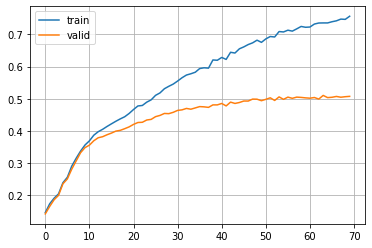

In [0]:
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.legend()
plt.grid()

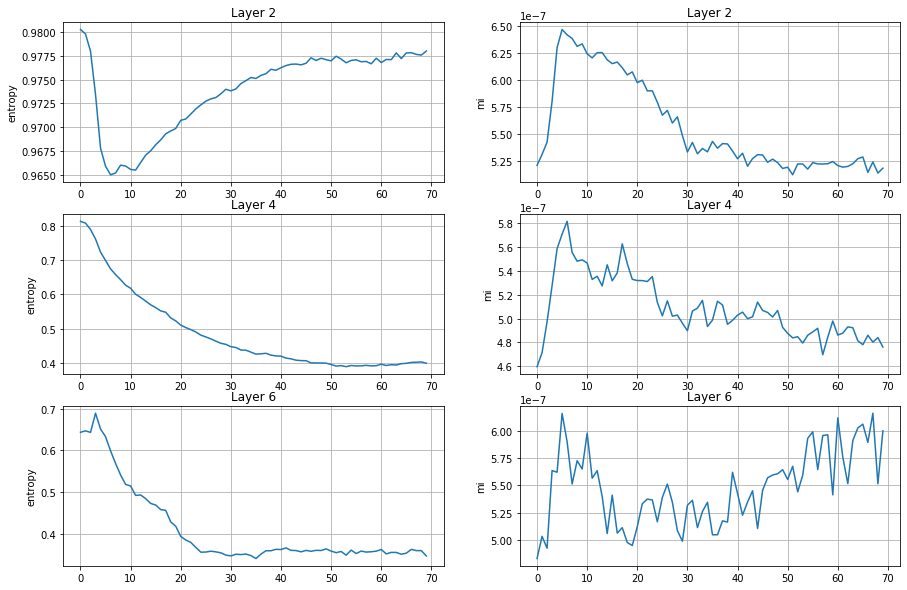

In [0]:
plt.figure(figsize=(15,10))
for i, layer_ind in enumerate(intermediate_layers):
    plt.subplot(3, 2, i*2 + 1)
    plt.plot(np.mean(stats[i][0], -1))
    plt.title("Layer {}".format(layer_ind))
    plt.ylabel("entropy")
    plt.grid()
    plt.subplot(3, 2, i*2 + 2)
    plt.plot(np.mean(stats[i][1], -1))
    plt.title("Layer {}".format(layer_ind))
    plt.ylabel("mi")
    plt.grid()

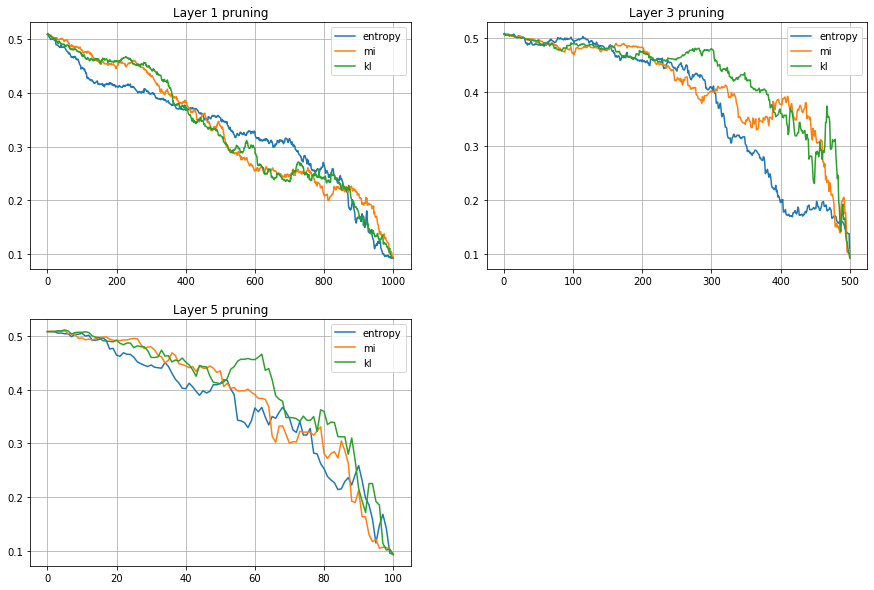

In [0]:
from copy import deepcopy
plt.figure(figsize=(15,10))
for i, layer_ind in enumerate(intermediate_layers):
    plt.subplot(2, 2, i + 1)
    plt.title("Layer {} pruning".format(layer_ind - 1))
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[layer_ind - 1],
                             np.argsort(stats[i][0][-1]), valid_loader)
    plt.plot(pruning_acc, label='entropy')
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[layer_ind - 1],
                             np.argsort(stats[i][1][-1]), valid_loader)
    plt.plot(pruning_acc, label='mi')
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[layer_ind - 1],
                             np.argsort(stats[i][2][-1].max(-1)), valid_loader)
    plt.plot(pruning_acc, label='kl')
    plt.grid()
    plt.legend()